In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set()
except ImportError:
    pass

import torch
from torch.autograd import Variable
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

torch.manual_seed(101)

# Simple Example of Pyro Inference
## Weighing Scale example

## Weighing Scale example

In [20]:
def scale(guess): # pass in a prior guess of the weight by some function of material knowledge, 
    
    #The weight will be around the guess
    weight = pyro.sample ("weight", dist.normal, guess, Variable(torch.ones(1))) #variability based on our knowledge
    #now we encode our belief about the noisiness of the scale
    # the measurement fluctuates around the true weight.
    return pyro.sample("measurement", dist.normal, weight, Variable(torch.Tensor([0.75])))

#### Marginalization in Pyro with pyro.infer.Marginal is split into two steps. First, we collect a number of weighted execution traces of the model. Then, we can collapse those traces into a histogram over possible return values given a particular set of arguments.

In [21]:

posterior = pyro.infer.Importance(scale, num_samples=100)

"""posterior is not a particularly useful object on its own, 
though advanced users can call it with arguments for scale to sample a raw execution trace. 
Instead, posterior is meant to be consumed by pyro.infer.Marginal, 
which creates a primitive stochastic function with the same input and output types as scale."""

'posterior is not a particularly useful object on its own, \nthough advanced users can call it with arguments for scale to sample a raw execution trace. \nInstead, posterior is meant to be consumed by pyro.infer.Marginal, \nwhich creates a primitive stochastic function with the same input and output types as scale.'

In [22]:
guess = Variable(torch.Tensor([8.5]))
marginal = pyro.infer.Marginal(posterior)
'''When called with an input guess, marginal first uses posterior to generate a sequence of weighted execution
traces given guess, then builds a histogram over return values from the traces, and 
finally returns a sample drawn from the histogram. 
Calling marginal with the same arguments more than once will sample from the same histogram'''

print(marginal(guess))

#IMPORTANT: Marginal has a marginal DISTRIBUTION, represented internally as a histogram built from the sample traces.
# it can be used like a primitive stochastic function, and for us to get samples from it.

Variable containing:
 7.9588
[torch.FloatTensor of size 1]



Text(0,0.5,u'#')

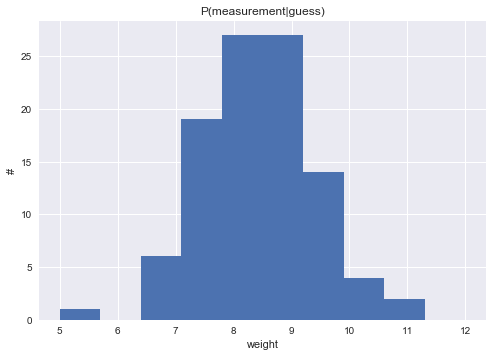

In [23]:
plt.hist([marginal(guess).data[0] for _ in range(100)], range = (5.0,12.0))
plt.title("P(measurement|guess)")
plt.xlabel("weight")
plt.ylabel("#")

##### pyro.infer.Marginal also accepts the optional keyword argument sites=[name1, name2, ...] that provides a list of names of latent variables. When sites is specified, marginal will return a dictionary where the keys are the names in sites and the values are values at those sites from a single execution trace. This is useful because we may wish to compute many different marginals from the same posterior object. 
##### SELF NOTE: We get the latent variable values as well ! we can get the marginals of latent vars from the same posterior object !! 
##### SELF NOTE 2: A marginal (I think) is helpful for computational complexity/cost when computing larger marginals (built on more vars). A sort of hierarchy and separation (unsure, review later with more info)

##### pyro.infer.Marginal also accepts the optional keyword argument sites=[name1, name2, ...] that provides a list of names of latent variables. When sites is specified, marginal will return a dictionary where the keys are the names in sites and the values are values at those sites from a single execution trace. This is useful because we may wish to compute many different marginals from the same posterior object. 
##### SELF NOTE: We get the latent variable values as well ! we can get the marginals of latent vars from the same posterior object !! 
##### SELF NOTE 2: A marginal (I think) is helpful for computational complexity/cost when computing larger marginals (built on more vars). A sort of hierarchy and separation (unsure, review later with more info)
# Conditioning Models on Data
### In this we condition/constrain a sample/set of sampling functions to match an observation, either before or after. Changes the data generation to work with the conditioned/OBSERVED variable.


### In this we condition/constrain a sample/set of sampling functions to match an observation, either before or after. Changes the data generation to work with the conditioned/OBSERVED variable.


In [24]:
conditioned_scale = pyro.condition(scale,
            data = {"measurement": Variable(torch.Tensor([8.5]))})

In [25]:
#alternatively we can also write functions that do the conditioning later
def deferred_conditioned_scale(cond_measure, *args, **kwards):
    return pyro.condition(scale,data = {"measurement":cond_measure})

In [26]:
#you can also pass in conditions DIRECTLY to the sample statements
# equivalent to pyro.condition(scale, data={"measurement": Variable(torch.ones(1))})
def scale_obs(guess):
    z = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
     # here we attach an observation measurement == 1
    return pyro.sample("measurement", dist.normal, weight, Variable(torch.ones(1)),
                       obs=Variable(torch.Tensor([0.1])))
# IMPORTANT: Pyro.observe is the same as pyro.sample with the observation
# parameter being necessary
def scale_obs(guess):
    z = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
    # here we attach an observation measurement == 1
    return pyro.observe("measurement", dist.normal, Variable(torch.ones(1)),
                        weight, Variable(torch.Tensor([0.1])))

#### IMPORTANT: The only restriction is that a single site may only be constrained once. Often it is better to condition it later as needed

#### IMPORTANT: The only restriction is that a single site may only be constrained once. Often it is better to condition it later as needed
### Composing /combining conditions

In [27]:
def scale2(guess):#first lets define the scale2 function that has tolerance too
    weight = pyro.sample("weight",
            dist.normal, guess, Variable(torch.ones(1)))
    tolerance = torch.abs(pyro.sample("tolerance",
                    dist.normal, Variable(torch.zeros(1)),
                    Variable(torch.ones(1)) ))
    return pyro.sample("measurement", dist.normal, weight, tolerance)
    

###### now all the following are equivalent conditioning and DO NOT AFFECT EACH OTHER

In [28]:
conditioned_scale2_1 = \
    pyro.condition(
        pyro.condition(scale2, data = {"weight":Variable(torch.ones(1))})
        , data = {"measurement":Variable(torch.ones(1))}
    )
conditioned_scale2_2 = \
    pyro.condition(
        pyro.condition(scale2, data = {"measurement":Variable(torch.ones(1))})
        , data = {"weight":Variable(torch.ones(1))}
    )    
#we can do this with only one condition statement. 
# these are just constraints on the overall system, order does not
#matter in which we specify the constraints
conditioned_scale2_2 = \
    pyro.condition(scale2,
                   data = {"weight":Variable(torch.ones(1)),
                      "measurement":Variable(torch.ones(1))}
    )        

###### Apparently these is a Pyro.do operator that is like Pearl's do operator. Used for causal inference (given observations what laten vars could have caused it). Verbatim from tutorial "identical interface to pyro.condition. condition and do can be mixed and composed freely, making Pyro a powerful tool for model-based causal inference"


# FLEXIBLE APPROX INFERENCE w GUIDE FUNCTIONS

{'weight': Variable containing:
 8.3751
[torch.FloatTensor of size 1]
}


Text(0,0.5,u'#')

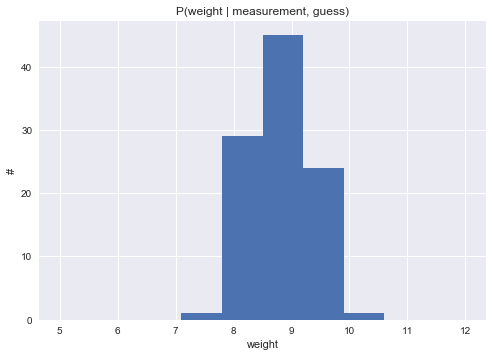

In [29]:
''' We could do pure importance sampling for eastimating the parameters.
In our case, we could estimate the weight given the guess, and 
the measurement==data observation. We can do the same approach as we saw
previously for imp sampling with the conditioned model as well

IMPORTANT: pay attention to the sites parameter in the "marginal" var
assignment below
'''
guess = Variable(torch.Tensor([8.5]))
measurement = Variable(torch.Tensor([9.5]))

conditioned_scale = pyro.condition(scale, 
                        data={"measurement": measurement})

marginal = pyro.infer.Marginal(
            pyro.infer.Importance(conditioned_scale, num_samples=100),
            sites=["weight"])

# The marginal distribution concentrates around the data
print(marginal(guess))
#IMPORTANT: Recall that the marginal itself is a stochastic function 
# that we can sample from
plt.hist([marginal(guess)["weight"].data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

# To be a valid guide function for a var
#### 1. all unobserved sample statements that appear in the model appear in the guide. 
These NOTES NEED REVIEW
EXAMPLE: The measurement that we have observed is x. The guide should have/handle other measurement values as well.
(Self note: So we expect the ones that we have sampled are the high probability ones, and for the other samples, we can be content with the guide/approximation probability. Saves on computational efficiency)
#### 2. the guide has the same input signature as the model (i.e. takes the same arguments)

IMPORTANT The precise meaning of the guide is different across different inference algorithms. Guide function is chosen so that it closely approximates the distribution over all unobserved sample statements in the model. The simplest guide for deferred_conditioned_scale matches the prior distribution over weight:


In [34]:
def scale_prior_guide(guess):
    return pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))

posterior = pyro.infer.Importance(conditioned_scale,
                                  guide=scale_prior_guide,
                                  num_samples=10)

marginal = pyro.infer.Marginal(posterior, sites=["weight"])

In [35]:
def scale_posterior_guide(measurement, guess):
    # note that torch.size(measurement, 0) is the total number of measurements
    # that we're conditioning on
    a = (guess + torch.sum(measurement)) / (measurement.size(0) + 1.0)
    b = Variable(torch.ones(1)) / (measurement.size(0) + 1.0)
    return pyro.sample("weight", dist.normal, a, b)

posterior = pyro.infer.Importance(deferred_conditioned_scale,
                                  guide=scale_posterior_guide,
                                  num_samples=20)

marginal = pyro.infer.Marginal(posterior, sites=["weight"])
plt.hist([marginal(measurement, guess)["weight"].data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

KeyError: 'weight'

# FOR THE ABOVE, true posterior. Derive it from the graph and your understanding. or ack that it is a hold

# google variational distributions and STOCH variational inference